<p align="center"> <img src="https://www.motorbiscuit.com/wp-content/uploads/2020/03/Used-Car-Dealership-Getty-5.jpg"> </p> 

# Predicting used cars prices in the Canadian market

When it comes to shopping for a used car, budget is one of the main constraints. Prices can differ for a variety of factors, and the experience is quite different than buying a new vehicle. The search process is the first step, and thanks to the internet, the buyer has access to a wealth of information and reviews. With all that said, there is virtually no way to know if an offer is **fair** or **overpriced**. In practice, *prior experience* and *extensive search* can help. How about using machine learning and data analysis to simplify the process and provide **unbiased** advice to the shopper?  
In the following notebook, I will design and present two machine learning algorithms that will predict used car prices in Canada. The same process could be followed to obtain similar prediction software for the US market.  
 First, an exploratory data analysis (EDA) will be performed on a dataset that will be downloaded from **Kaggle**. In the second step, features will be engineered to train and tune two different machine learning regression algorithms.  
 This project is part of the [Zero to Data Science Bootcamp by Jovian](https://jovian.ai/learn/zero-to-data-analyst-bootcamp).

## 1- Download used cars market data  
In this section, we will install and import all the libraries that will be used throughout the notebook. After that, a large dataset of used cars listings (from Canada and the US) will be downloaded. We will focus on the canadian data, but similar approach can be used to explore the listings from the US.

In [ ]:
# download and import the libraries

!pip install opendatasets pandas numpy matplotlib seaborn tqdm sklearn xgboost  --quiet
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import opendatasets as od
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

The library `OpenDataSets` by **Jovian** is a conveniant tool to get data from Kaggle. It requires a username and password from the account.

In [ ]:
# download data
filepath = '.\\data\\marketcheck-automotive-data-us-canada'
url = 'https://www.kaggle.com/rupeshraundal/marketcheck-automotive-data-us-canada?select=ca-dealers-used.csv'
if not(os.path.exists(filepath)):
    od.download_kaggle_dataset(url, filepath)    

This will download two seperate `csv` files. Let's explore the `ca-dealers-used.csv` file using `Pandas`.

In [ ]:
# read csv data 
canada_ds = pd.read_csv(filepath+'\\ca-dealers-used.csv', low_memory=False)
canada_ds.head(3) 

Each transaction is detailled through multiple columns. The `VIN` number is unique to each car. This field will be used later to remove duplicates. Let's show the properties for each column.

In [ ]:
canada_ds.info()

It appears that some columns lack informations for a certain number of transactions. 

In [ ]:
canada_ds.isna().sum()

We choose to drop all the rows missing pieces of information since we still will have a sufficient amount of data. Before that, we will drop all the columns that won't be used.

In [ ]:
unused_columns = ['id', 'stock_no','seller_name', 'street','trim','engine_size', 
                'zip','body_type','fuel_type', 'engine_block','vehicle_type']
canada_ds.drop(unused_columns,axis = 1, inplace=True)
canada_ds.dropna(inplace=True)

Then, we remove all duplicates using the same `vin` number.

In [ ]:
canada_ds.drop_duplicates('vin', inplace=True)
canada_ds.info()

The resulting data frame contains more than 172000 records, with no duplicate and no missing fields. Let's display more details about the column `state`.

In [ ]:
#fix state information
canada_ds.state.unique()

`OH`, `NC` and `SC` do not represent canadian provinces. To fix this problem, we display the `city` values.

In [ ]:
canada_ds[canada_ds['state']=='OH']['city'].unique()

After some search, it turns out that *Woodbridge* is a city in Ontario. We just have to replace the values in the data frame. 

In [ ]:
canada_ds['state'].replace('OH','ON',inplace=True)

We proceed the same way with `SC` and `NC`. We found that `NC` doesn't contain any record in a canadian city, and `SC` contains records in **Quebec city, QC**.

In [ ]:
canada_ds.drop(index = canada_ds[canada_ds.state=='NC'].index, inplace=True)
canada_ds['state'].replace('SC','QC',inplace=True)

The column `year` provides the model year of the car. 

In [ ]:
canada_ds['year'].describe()

The data is a snapshot of the listings in 2021, with some cars labeled as from year 2022. This is a common practice in the automotive industry, known as the **model year**. We could create a column `age` using the data from `year`.

In [ ]:
# create Age column 
canada_ds['age'] = 2022- canada_ds['year'] 

One last improvment to our data is to remove outliers, but limiting the age, price and mileage of cars.

In [ ]:
# filter very expensive and very old cars (outliers)
canada_ds=canada_ds[canada_ds['age']<25]
canada_ds=canada_ds[canada_ds['price']<100000]
canada_ds=canada_ds[canada_ds['miles']<200000]
canada_ds.info()

## 2- Exploratory Data Analysis

In this section, we will display some graphs to get an intuition about the data that will be used to design the prediction algorithms.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
fig = sns.scatterplot(y ='price',x='miles', hue = 'age',data =canada_ds,s=25);
fig.set(xlabel = 'Mileage', ylabel = 'Price', title = 'Relationship between mileage, age and price');

It appears that expensive cars are either recent or have low mileage. There are some exceptions (consider the dark points) where some old cars can hold a high value, regardless of the mileage.  
This next graphs show the most expensive, and the less expensive car makes in the market.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (luxury brands)');
plt.figure()
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=True).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (economy brands)');

Let's explore which drivetrain is more common in Canada.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'drivetrain'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Drivetrain', title = 'Number of listings for each drivetrain type');

With no surprise, `4wd` cars are very common in Canada, due to its well-known winter!  
The next graph will show how `Automatic` transmissions are more prefered in the canadian market.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'transmission'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Transmission', title = 'Number of listings for each transmission type');

Used vehicles are more expensive in some provinces, due to standard of living, taxes and emission control. This is shown in the next graph.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Average price', ylabel = 'Province', title = 'Average price for each province');

The market share of each provice is related to its population size. As we show on the next plot, Ontario has the highest number of listings (and the largest population).

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Province', title = 'Number of listings for each province');

## 3- Prepare data for machine learning

After cleaning the data, we select the most suitable features to predict/evaluate a used car price. Here is a list of available features in the dataframe: 

In [ ]:
canada_ds.columns

The output of our model will be obviously the **price**. We will not use the **VIN** number, and split the remaining features into two classes: numeric and categorical columns.  
Note that a very important piece of information is missing here: **the car condition**. In the used car market, two very identical vehicles can have large price differences due to previous maintenance, accident history, rust, and interior condition. This missing information will affect the precision of the prediction process.

In [ ]:
target_cols = ['price']
features_num_cols = ['miles', 'age',]
features_cat_cols = ['make', 'model', 'drivetrain', 'transmission','state', 'city']

In [ ]:
raw_data = canada_ds[features_num_cols+features_cat_cols+target_cols].copy()
print('Average price is ${:.2f}'.format(raw_data['price'].mean()))

The model output (*price*), has an average of $25k. The performance metrics of the regressions will be compared to this value.

First, we split the data into training, validation and testing sets.

In [ ]:
# split train, test and val
# remove annoying warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(raw_data, test_size = 0.2)
train_data, val_data = train_test_split(trainval_data, test_size = 0.25)

The numeric features will be scaled using *scikit learn* minmax scaler.

In [ ]:
# normalize numeric inputs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data[features_num_cols])
train_data[features_num_cols] = scaler.transform(train_data[features_num_cols])
test_data[features_num_cols] = scaler.transform(test_data[features_num_cols])
val_data[features_num_cols] = scaler.transform(val_data[features_num_cols])


The categorical features will be transformed via a one hot encoding strategy.

In [ ]:
# one hot encoding categorical inputs
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_data[features_cat_cols])
new_one_hot_cols = list(encoder.get_feature_names(features_cat_cols))
train_data[new_one_hot_cols] = encoder.transform(train_data[features_cat_cols])
test_data[new_one_hot_cols] = encoder.transform(test_data[features_cat_cols])
val_data[new_one_hot_cols] = encoder.transform(val_data[features_cat_cols])

These transformations increase the number of features.

In [ ]:
print('number of features ={}'.format(len(features_num_cols + new_one_hot_cols)))

The last step will be to create input and output dataframes for each set.

In [ ]:
# create input and output dataframes
train_inputs = train_data[features_num_cols + new_one_hot_cols]
test_inputs = test_data[features_num_cols + new_one_hot_cols]
val_inputs = val_data[features_num_cols + new_one_hot_cols]

train_output = train_data[target_cols]
test_output = test_data[target_cols]
val_output = val_data[target_cols]

## 4- Predicting the price using machine learning 

In this part, we will train and tune two different machine learning regression algorithms. The first method is based on gradient boosting, using the library **XGBoost**.

### 4-1 Regression using XGBoost

In [ ]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor 

**XGBoost** has multiple hyperparameters. In this notebook, we will tune two parameters:
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- n_estimators: Number of trees. A high number of trees will most likely lead to overfitting.

In [ ]:
# max_depth selection
n_init = 5 # this will be tuned later
results=[]
for max_depth in tqdm(range(5,51,5)):
    model = XGBRegressor(n_estimators = n_init, max_depth = max_depth)
    model.fit(train_inputs, train_output)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    error_train = mean_squared_error(train_output, train_preds, squared=False)
    error_val = mean_squared_error(val_output, val_preds, squared=False)
    print('max_depth = {}'.format(max_depth),"RMS_error_train = {:.2f} *** RMS_error_val = {:.2f}".format(error_train,error_val))
    results.append([max_depth,error_train, error_val, model])

In [ ]:
params = [results[i][0] for i in range(len(results))]
T_e = [results[i][1] for i in range(len(results))]
V_e = [results[i][2] for i in range(len(results))]
fig = sns.lineplot(x = params, y=  V_e, color = 'red');
fig = sns.lineplot(x = params, y=  T_e, color = 'green');
fig.set(xlabel = 'max_depth', ylabel = 'RMSE', Title='RMSE error on training and validation sets');
fig.legend(title='Data set', labels = ['Validation','Training']);

In [ ]:
# n_estimators selection
max_depth_opt = 40
results =[]
for n_estimators in tqdm(range(10,61,5)):
    model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth_opt)
    model.fit(train_inputs, train_output)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    error_train = mean_squared_error(train_output, train_preds, squared=False)
    error_val = mean_squared_error(val_output, val_preds, squared=False)
    print('n_estimators = {}'.format(n_estimators),"RMS_error_train = {:.2f} *** RMS_error_val = {:.2f}".format(error_train,error_val))
    results.append([n_estimators, error_train, error_val, model])

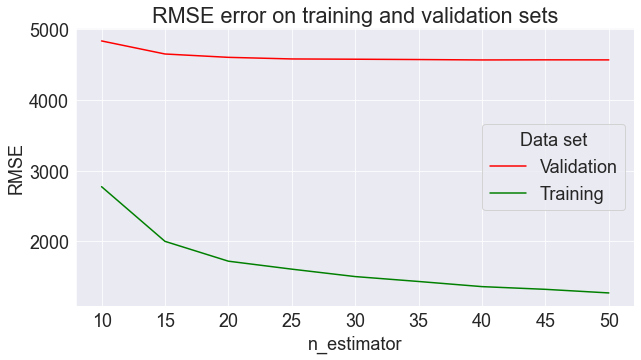

In [88]:
params = [results[i][0] for i in range(len(results))]
T_e = [results[i][1] for i in range(len(results))]
V_e = [results[i][2] for i in range(len(results))]
fig = sns.lineplot(x = params, y=  V_e, color = 'red');
fig = sns.lineplot(x = params, y=  T_e, color = 'green');
fig.set(xlabel = 'n_estimator', ylabel = 'RMSE', Title='RMSE error on training and validation sets');
fig.legend(title='Data set', labels = ['Validation','Training']);

In [92]:
# Decision tree
# max_depth tuning
from sklearn.tree import DecisionTreeRegressor
results =[]
for max_depth in tqdm(range(1,200,10)):
    model = DecisionTreeRegressor(max_depth = max_depth )
    model.fit(train_inputs, train_output)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    error_train = mean_squared_error(train_output, train_preds, squared=False)
    error_val = mean_squared_error(val_output, val_preds, squared=False)
    print('max_depth = {}'.format(max_depth),"RMS_error_train = {:.2f} *** RMS_error_val = {:.2f}".format(error_train,error_val))
    results.append([max_depth, error_train, error_val, model])

n_neighbors = 1 RMS_error_train = 12954.48 *** RMS_error_val = 12952.88
n_neighbors = 11 RMS_error_train = 8427.76 *** RMS_error_val = 8747.76
n_neighbors = 21 RMS_error_train = 6294.84 *** RMS_error_val = 7237.46
n_neighbors = 31 RMS_error_train = 4690.53 *** RMS_error_val = 6489.11
n_neighbors = 41 RMS_error_train = 3490.40 *** RMS_error_val = 6029.88
n_neighbors = 51 RMS_error_train = 2744.58 *** RMS_error_val = 5906.22
n_neighbors = 61 RMS_error_train = 2177.78 *** RMS_error_val = 5864.66
n_neighbors = 71 RMS_error_train = 1743.82 *** RMS_error_val = 5805.22
n_neighbors = 81 RMS_error_train = 1382.91 *** RMS_error_val = 5801.65
n_neighbors = 91 RMS_error_train = 1115.42 *** RMS_error_val = 5811.25
n_neighbors = 101 RMS_error_train = 868.43 *** RMS_error_val = 5822.10
n_neighbors = 111 RMS_error_train = 558.21 *** RMS_error_val = 5825.27
n_neighbors = 121 RMS_error_train = 416.10 *** RMS_error_val = 5821.57
n_neighbors = 131 RMS_error_train = 328.13 *** RMS_error_val = 5814.75
n_nei

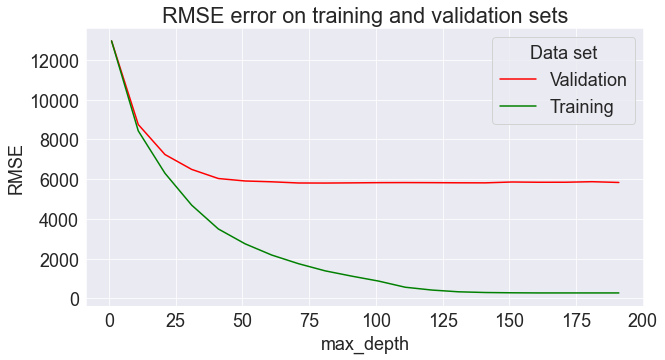

In [93]:
params = [results[i][0] for i in range(len(results))]
T_e = [results[i][1] for i in range(len(results))]
V_e = [results[i][2] for i in range(len(results))]
fig = sns.lineplot(x = params, y=  V_e, color = 'red');
fig = sns.lineplot(x = params, y=  T_e, color = 'green');
fig.set(xlabel = 'max_depth', ylabel = 'RMSE', Title='RMSE error on training and validation sets');
fig.legend(title='Data set', labels = ['Validation','Training']);

In [96]:
# max_leaf_nodes tune
results =[]
for max_leaf_nodes in tqdm(range(2,2**20,10000)):
    model = DecisionTreeRegressor(max_depth = 80, max_leaf_nodes=max_leaf_nodes )
    model.fit(train_inputs, train_output)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    error_train = mean_squared_error(train_output, train_preds, squared=False)
    error_val = mean_squared_error(val_output, val_preds, squared=False)
    print('max_leaf_nodes = {}'.format(max_leaf_nodes),"RMS_error_train = {:.2f} *** RMS_error_val = {:.2f}".format(error_train,error_val))
    results.append([max_leaf_nodes, error_train, error_val, model])

max_leaf_nodes = 1024 RMS_error_train = 5064.98 *** RMS_error_val = 5799.67
max_leaf_nodes = 1280 RMS_error_train = 4775.53 *** RMS_error_val = 5701.78
max_leaf_nodes = 1536 RMS_error_train = 4542.53 *** RMS_error_val = 5596.28
max_leaf_nodes = 1792 RMS_error_train = 4354.96 *** RMS_error_val = 5564.00
max_leaf_nodes = 2048 RMS_error_train = 4188.76 *** RMS_error_val = 5548.11
max_leaf_nodes = 2304 RMS_error_train = 4043.70 *** RMS_error_val = 5559.09
max_leaf_nodes = 2560 RMS_error_train = 3918.37 *** RMS_error_val = 5532.11
max_leaf_nodes = 2816 RMS_error_train = 3810.31 *** RMS_error_val = 5532.45
max_leaf_nodes = 3072 RMS_error_train = 3712.17 *** RMS_error_val = 5523.49
max_leaf_nodes = 3328 RMS_error_train = 3624.82 *** RMS_error_val = 5489.06
max_leaf_nodes = 3584 RMS_error_train = 3546.53 *** RMS_error_val = 5530.19
max_leaf_nodes = 3840 RMS_error_train = 3470.75 *** RMS_error_val = 5511.36
max_leaf_nodes = 4096 RMS_error_train = 3402.15 *** RMS_error_val = 5532.98
max_leaf_nod

KeyboardInterrupt: 

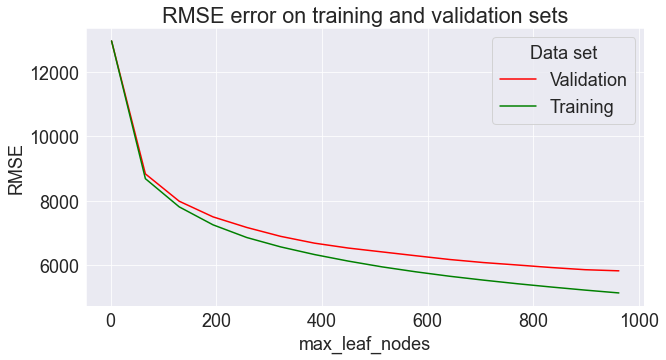

In [ ]:
params = [results[i][0] for i in range(len(results))]
T_e = [results[i][1] for i in range(len(results))]
V_e = [results[i][2] for i in range(len(results))]
fig = sns.lineplot(x = params, y=  V_e, color = 'red');
fig = sns.lineplot(x = params, y=  T_e, color = 'green');
fig.set(xlabel = 'max_leaf_nodes', ylabel = 'RMSE', Title='RMSE error on training and validation sets');
fig.legend(title='Data set', labels = ['Validation','Training']);

In [ ]:
# neural network ?
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

network = models.Sequential()
network.add(layers.Dense(2000 , activation='relu' , input_dim=len(features_num_cols + new_one_hot_cols))) 
network.add(layers.Dense(2000 , activation='relu')) 
network.add(layers.Dense(1)) 

network.compile(optimizer='adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])

# Training 
n_epochs =2000
result = network.fit(train_inputs, train_output,epochs = n_epochs,verbose=1, batch_size = 10000,
                     validation_data=(val_inputs,val_output),callbacks = [es])

## 5- Conclusion and future work